## (2) Create a smooth trajectory

Next we'll create smoothed taxi path. We will use splines in the implementation of the python drawing library matplotlib.

In [32]:
from __future__ import division # python 2.7
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import datashader as ds
import datashader.transfer_functions as tf
import math

First let's import a single taxi file. 

As before, to **run** the notebook (taxi-trajectory.ipynb) you'll need to unzip t-drive-sample-part1.zip. 

In [33]:
column_names = ['taxi_id', 'date_time', 'longitude', 'latitude'] # the new dataframe column names
path = r'/Users/pierre.dueck/ds/startupML/t-drive-sample-part1/01/2669.txt'
df = pd.read_csv(path, names=column_names)
df['date_time'] = pd.to_datetime(df.date_time) # Correct the type in date_time column
df.head()

,taxi_id,date_time,longitude,latitude
0,2669,2008-02-02 13:30:49,116.45087,39.98648
1,2669,2008-02-02 13:30:54,116.45080,39.98665
2,2669,2008-02-02 13:30:59,116.45087,39.98679
3,2669,2008-02-02 13:31:04,116.45115,39.98720
4,2669,2008-02-02 13:31:09,116.45138,39.98728


Let's check the pattern of sampling times... it looks very consistent.

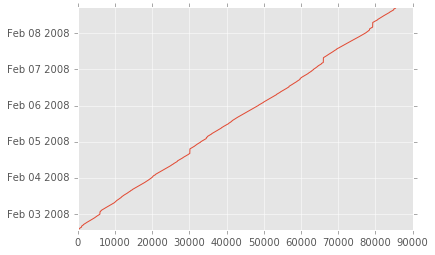

In [34]:
plt.plot(df.date_time)
plt.show()

Now let's take a look at the gps points within the city. To do this, we have to throw out some outliers.

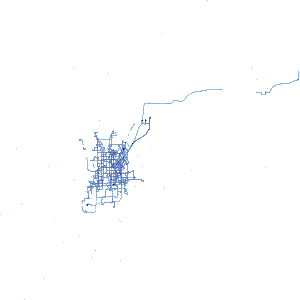

In [14]:
df = df[abs(df.longitude -116.4) <= 2]
df = df[abs(df.latitude - 39.9) <= 2]
cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(df,'longitude','latitude')
img = tf.shade(agg, cmap=['lightblue','darkblue'],how='log')
img

Now let's check the spline fit that matplotlib will give us.

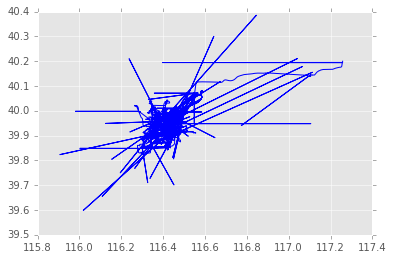

In [16]:
plt.plot(df.longitude,df.latitude,'b')
plt.show()

Oh boy...

## Speed (mph)
Ok let's check velocities, throwing away anything out of the ordinary. First, define the formula to compute distances from gps points. 

In [25]:
# Formula to compute distance between gps points (in meters)

def gps_dist(a, b, c, d):    
    '''Compute the distance (in meters) between two gps locations. Input is assumed to be a = longitude, b = latitude, etc.'''
    r = 0.0174533  # 1 degree in radians
    return 2 * 6371000 * np.arcsin( np.sqrt( # https://en.wikipedia.org/wiki/Haversine_formula
        np.sin(r*(d - b)/2.0)**2 + np.cos(r*b) * np.cos(r*d) * np.sin(r*(c - a)/2.0)**2))


# Compute distances. Convert from meters/second to miles per hour.

df['time_diffs'] = df['date_time'].diff().astype('timedelta64[s]') 
df['dist'] = gps_dist(df.longitude,df.latitude, df.longitude.shift(),df.latitude.shift())
df['speed'] = 2.23694 * ( df.dist / df.time_diffs) # m/s to mph

Ok let's take a look at the speeds.

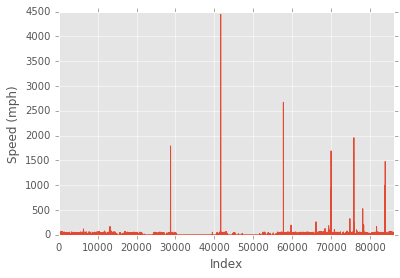

In [26]:
df_speeds = df.speed.plot()
df_speeds.set_xlabel("Index")
df_speeds.set_ylabel("Speed (mph)")
plt.show()

Ok, I'm guessing the taxi cab can't go that fast... so let's assume they don't go over 60mph, say.

In [28]:
df = df[df.speed <= 60]

Now let's check the data.

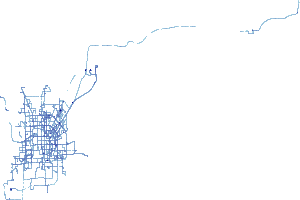

In [29]:
cvs = ds.Canvas(plot_width=300, plot_height=200)
agg = cvs.points(df,'longitude','latitude')
img = tf.shade(agg, cmap=['lightblue','darkblue'],how='log')
img

Ok let's see how well the splines in matplotlib do.

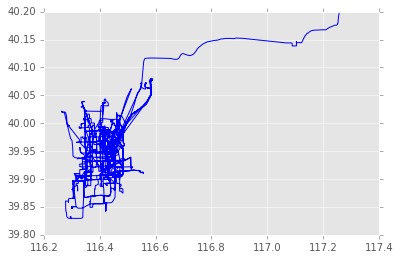

In [30]:
plt.plot(df.longitude,df.latitude,'b')
plt.show()